# LSTM Modelinin Alt Kelime Veri Seti İle Kullanılması

Bu colab dosyasında, bir gömme (`Embedding`) katmanına sahip bir model kullanmanın ve ardından çift yönlü (`Bidirectional`) LSTM katmanları eklemenin sonuçlarını karşılaştıracağız.

Amazon ve Yelp incelemelerini (yorumlarını) içeren bir  alt sözcükler veri kümesi ile çalışacağız.

Ve yeni yorumların duygusunu (iyi veya kötü) tahmin etmek için bu modelleri kullanacağız.

In [2]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

Amazon ve Yelp incelemelerini (yorumlarını) içeren veri setini ilgili duyarlılıklarıyla birlikte alarak başlayalım (olumlu için 1, olumsuz için 0). Bu veri seti orijinal olarak [buradan](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set) alınmıştır.

In [3]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P -O /tmp/sentiment.csv

--2021-07-28 17:27:42--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 74.125.137.101, 74.125.137.100, 74.125.137.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.137.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bdju12bi7tplr6sbqajeemktvpa4675q/1627493250000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2021-07-28 17:27:43--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bdju12bi7tplr6sbqajeemktvpa4675q/1627493250000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|142.2

In [4]:
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')

# Cümleleri ve etiketleri ayıklayın
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

In [5]:
# Bazı örnek cümleler ve etiketler yazdırın
for x in range(2):
  print(sentences[x])
  print(labels[x])
  print("\n")

So there is no way for me to plug it in here in the US unless I go by a converter.
0


Good case Excellent value.
1




## Alt Kelime Veri Kümesinin Oluşturulması

Amazon ve Yelp incelemeleri veri setini `tensorflow_datasets` tarafından sunulan `SubwordTextEncoder` işleviyle kullanacağız.

`SubwordTextEncoder.build_from_corpus()` bizim için bir belirteç (tokenize edici)oluşturacaktır. Bu işlevi aynı zamanda çok daha büyük bir metin bütününden alt sözcükler almak için de kullanabilirsiniz, ancak biz burada sadece mevcut veri setimizi kullanacağız.

Yalnızca en yaygın 1.000 alt kelimeden oluşan bir alt kelime veri seti oluşturacağız ve ayrıca her bir alt kelimeyi en fazla 5 karakter olacak şekilde keseceğiz.

Alt kelime metin kodlayıcı için ilgili belgelere [buradan](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder#build_from_corpus) göz atın.


In [6]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)

# Kelime boyutu ne kadar büyük?
print("Kelime boyutu :  ", tokenizer.vocab_size)

Kelime boyutu :   999


In [7]:
# Belirteç oluşturucunun (tokenize edici) uygun şekilde çalışıp çalışmadığını kontrol edin
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [8]:
# Her bir alt sözcüğü ayrı ayrı yazdırın ve decode işlemi uygulayın
for i in encoded:
  print(tokenizer.decode([i]))

I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


## Cümle Verilerini Kodlanmış Alt Sözcüklerle Değiştirelim

Şimdi, bireysel cümlelerin her birini fiilen kodlayarak eğitim için kullanılacak dizileri oluşturacağız. Bu, önceki colab dosyalarındaki kullandığımız `Tokenizer` ile `text_to_sequences` ile eşdeğerdir.

In [9]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [10]:
# Cümlelerin uygun şekilde değiştirildiğini kontrol edin
print(sentences[5])

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


## Son Ön İşlemenin Yapılması

Eğitimden önce, dizileri doldurmanın yanı sıra eğitim ve test setlerine de ayırmamız gerekiyor.


In [11]:
import numpy as np

max_length = 50
trunc_type='post'
padding_type='post'

# Tüm dizileri doldurun
sequences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Cümleleri ve etiketleri eğitim ve test setlerine ayırın
training_size = int(len(sentences) * 0.8)

training_sequences = sequences_padded[0:training_size]
testing_sequences = sequences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Etiketleri daha sonra ağda kullanmak üzere numpy dizilerine dönüştürün
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Bir Gömme (Embedding) Uygulanarak Modelin Oluşturulması

In [12]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


## Modelin Eğitilmesi 

In [13]:
num_epochs = 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, validation_data=(testing_sequences, testing_labels_final))


Epoch 1/30
50/50 [==============================] - 4s 6ms/step - loss: 0.6915 - accuracy: 0.5348 - val_loss: 0.6968 - val_accuracy: 0.4211
Epoch 2/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6863 - accuracy: 0.5392 - val_loss: 0.6938 - val_accuracy: 0.4837
Epoch 3/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6789 - accuracy: 0.5825 - val_loss: 0.6865 - val_accuracy: 0.5188
Epoch 4/30
50/50 [==============================] - 0s 5ms/step - loss: 0.6656 - accuracy: 0.6422 - val_loss: 0.6752 - val_accuracy: 0.5639
Epoch 5/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6943 - val_loss: 0.6496 - val_accuracy: 0.7043
Epoch 6/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6144 - accuracy: 0.7608 - val_loss: 0.6315 - val_accuracy: 0.7018
Epoch 7/30
50/50 [==============================] - 0s 4ms/step - loss: 0.5786 - accuracy: 0.8010 - val_loss: 0.6084 - val_accuracy: 0.7093
Epoch 8/30
50/50 [==

## Doğruğun ve Kaybın Grafiğinin Çizilmesi

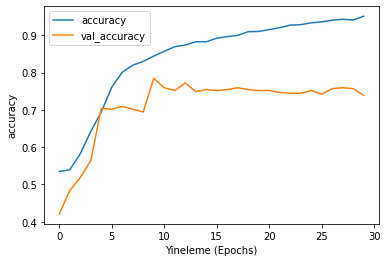

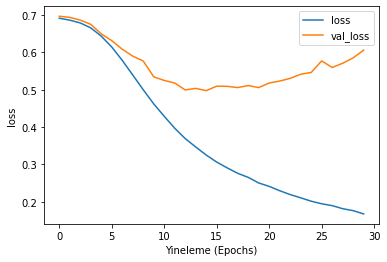

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Yineleme (Epochs)")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Yorumların Duygusunu Tahmin Etmek İçin Bir İşlev Tanımlanması

Bazı farklılıkları olan modeller oluşturacağız ve her bir modeli bazı yeni incelemelerin duyarlılığını tahmin etmek için kullanacağız.

Zaman kazanmak için, bir model ve bazı yeni incelemeleri alacak bir işlev oluşturalım ve her incelemenin sonucunda duyguları (olumlu veya olumsuz) yazdıralım.





In [15]:
# Bir dizi alan ve her bir yorumun olumlu mu olumsuz mu olduğunu 
# tahmin etmek için bir işlev tanımlıyoruz.

# max_length = 100 # Önceden tanımlanmış

def predict_review(model, new_sentences, maxlen=max_length, show_padded_sequence=True ):
  # Daha sonra kullanmaya devam edebilmemiz için orijinal cümleleri saklayın
  # Kodlanmış dizileri tutmak için bir dizi oluşturun
  new_sequences = []

  # Yeni incelemeleri dizilere dönüştürün
  for i, frvw in enumerate(new_sentences):
    new_sequences.append(tokenizer.encode(frvw))

  trunc_type='post' 
  padding_type='post'

  # Yeni incelemeler için tüm dizilere dolgu ekleyelim
  new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)             

  classes = model.predict(new_reviews_padded)

  # Etiket 1'e ne kadar yakınsa, inceleme o kadar olumlu olur
  for x in range(len(new_sentences)):
    
    # Diziyi yazdıralım
    if (show_padded_sequence):
      print(new_reviews_padded[x])
    # İnceleme metnini yazdıralım
    print(new_sentences[x])
    # Tahmin sonucumuzu yazdıralım (0-1 arası bir değer)
    print(classes[x])
    print("\n")

In [16]:
# Model tahminlerini yapalım 
fake_reviews = ["I love this phone", 
                "Everything was cold",
                "Everything was hot exactly as I wanted", 
                "Everything was green", 
                "the host seated us immediately",
                "they gave us free chocolate cake", 
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]

predict_review(model, fake_reviews)

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.9076681]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.10570715]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.3227498]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.09446277]


[  1 109 228 540 237 635 241

## Farklı Katmanlara Sahip Modellerin Sonuçlarını Eğitmek ve Göstermek İçin Bir İşlev Tanımlayalım

Bu colab doyasının geri kalanında modelleri tanımlayacağız ve ardından sonuçları göreceğiz.

Modeli alacak, derleyecek, eğitecek, doğruluk ve kayıp grafiğini çizecek ve ardından bazı sonuçları tahmin edecek bir fonksiyon tanımlayalım.

In [17]:
def fit_model_now (model, sentences) :
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, 
                      validation_data=(testing_sequences, testing_labels_final))
  return history

def plot_results (history):
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")

def fit_model_and_show_results (model, sentences):
  history = fit_model_now(model, sentences)
  plot_results(history)
  predict_review(model, sentences)

## Çift Yönlü (`Bidirectional`) LSTM Katmanının Eklenmesi

Çift yönlü LSTM kullanan yeni bir model oluşturalım.

Ardından, modeli derlemek, eğitmek, doğruluk ve kaybın grafiğini çıkarmak ve ardından bazı sonuçları tahmin etmek için önceden tanımladığımız işleve oluşturduğumuz modeli yollayalım.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                4224      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 20,429
Trainable params: 20,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 7s 21ms/step - loss: 0.6889 - accuracy: 0.5217 - val_loss: 0.7015 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 0s 9ms/step - loss: 0.6511 - accuracy: 0.5895 - val_los

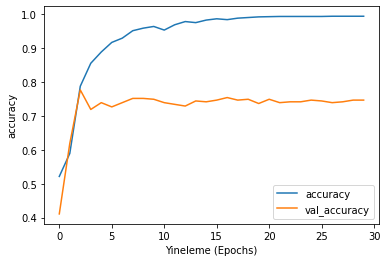

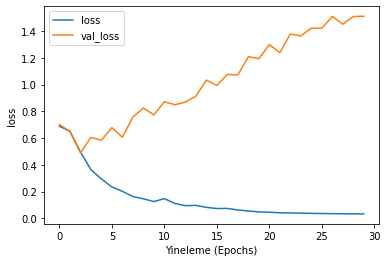

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.99850637]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.01973376]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.828015]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.02010954]


[  1 109 228 540 237 635 241

In [18]:
# Modelin tanımlanması
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(6, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Modeli derleyin ve eğitin ve ardından yeni cümlelerimiz için tahminleri gösterin
fit_model_and_show_results(model_bidi_lstm, fake_reviews)


## Birden Çok Çift Yönlü Katman Kullanılması

Şimdi modele başka bir çift yönlü LSTM katmanı ekleyelim ve sonrasında herhangi bir iyileştirme alıp almadığımızı görelim.

İlk `Bidirectional` LSTM katmanının bir dizi döndürdüğüne dikkat edelim.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 26,701
Trainable params: 26,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 6s 36ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.694

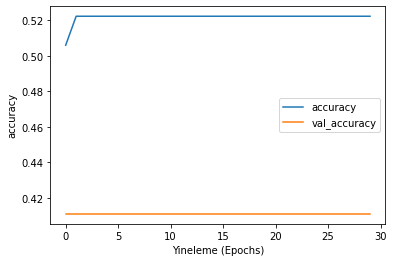

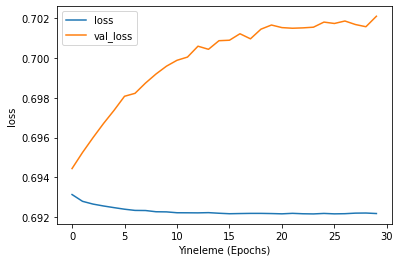

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.52231693]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.52231693]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.52231693]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.52231693]


[  1 109 228 540 237 635 2

In [19]:
model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

fit_model_and_show_results(model_multiple_bidi_lstm, fake_reviews)

## Tüm Modellerin Tahminlerinin Karşılaştırılması

Her bir modeli ayrı ayrı incelediğinizde hangi modelin farklı incelemeler için daha iyi bir tahmin verdiğini görmek zor olabilir. Karşılaştırma amacıyla, burada biraz daha yeni inceleme (yorum) tanımlıyoruz ve üç modelin her birinin her inceleme için verdiği tahminleri yazdırıyoruz:

- Gömme ve Global Ortalama Havuzlama katmanı içeren model
- Gömme ve Çift Yönlü LSTM katmanı içeren model
- Gömme ve iki Çift Yönlü LSTM katmanı içeren model

Sonuçlar her zaman beklediğiniz gibi olmayabilir. Girdi veri setimiz oldukça küçük, 2000'den daha az incelemeye sahiptir. İncelemelerin bazıları oldukça kısa ve kısa olanlardan bazıları oldukça tekrarlayıcı yorumlardır.Bu, şu iki inceleme gibi, modelin iyileştirilmesi üzerindeki etkilerini azaltır

- Bad Quality.
- Low Quality.

Kendinize ait daha fazla yorum eklemekten veya yorumları değiştirmekten çekinmeyin. Sonuçlar, incelemelerdeki kelimelerin birleşimine ve bunların eğitim setindeki incelemelerle ne kadar iyi eşleştiğine bağlı olacaktır.

Farklı modeller, olumlu bir kelime (Örn: iyi) içeren ancak kötü bir inceleme olan "iyi değildi" gibi şeyleri nasıl ele alıyor? Gelin bakalım


In [20]:
my_reviews =["lovely", "dreadful", "stay away",
             "everything was hot exactly as I wanted",
             "everything was not exactly as I wanted",
             "they gave us free chocolate cake",
             "I've never eaten anything so spicy in my life, my throat burned for hours",
             "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
             "we left there very full for a low price so I'd say you just can't go wrong at this place",
             "that place does not have quality meals and it isn't a good place to go for dinner",
             ]

In [21]:
print("===================================\n","Sadece gömme (Embedding) olan model:\n", "===================================",)
predict_review(model, my_reviews, show_padded_sequence=False)

 Sadece gömme (Embedding) olan model:
lovely
[0.9381704]


dreadful
[0.30828914]


stay away
[0.65018845]


everything was hot exactly as I wanted
[0.76869136]


everything was not exactly as I wanted
[0.55517656]


they gave us free chocolate cake
[0.7229566]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.02266356]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.58908224]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.7958421]


that place does not have quality meals and it isn't a good place to go for dinner
[0.8701938]




In [22]:
print("===================================\n", "Tek bir tane çift yönlü LSTM katmanı olan model:\n", "===================================")
predict_review(model_bidi_lstm, my_reviews, show_padded_sequence=False)

 Tek bir tane çift yönlü LSTM katmanı olan model:
lovely
[0.99842787]


dreadful
[0.0167416]


stay away
[0.06456801]


everything was hot exactly as I wanted
[0.9745891]


everything was not exactly as I wanted
[0.01740693]


they gave us free chocolate cake
[0.97438127]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.9872113]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.01448454]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.9999163]


that place does not have quality meals and it isn't a good place to go for dinner
[0.01283797]




In [23]:
print("===================================\n","İki tane çift yönlü LSTM katmanı olan model:\n", "===================================")
predict_review(model_multiple_bidi_lstm, my_reviews, show_padded_sequence=False)

 İki tane çift yönlü LSTM katmanı olan model:
lovely
[0.52231693]


dreadful
[0.52231693]


stay away
[0.52231693]


everything was hot exactly as I wanted
[0.52231693]


everything was not exactly as I wanted
[0.52231693]


they gave us free chocolate cake
[0.52231693]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.52231693]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.52231693]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.52231693]


that place does not have quality meals and it isn't a good place to go for dinner
[0.52231693]


